### Pytorch project: Detecting human emotion from facial expression

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# load up necessary libraries
import torch

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models

from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data import Subset, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import time
import math
from collections import Counter
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
# inspect the directory in the fer2013 folder
print(os.listdir('/kaggle/input/fer2013'))

['test', 'train']


## About Dataset FER2013  ![](https://storage.googleapis.com/kaggle-datasets-images/786787/1351797/89e6e907cb903b4f523bbd613e46b8a8/dataset-cover.png?t=2020-07-19-18-42-52)
The data consists of **48x48** pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories `(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)`. The training set consists of 28,709 examples and the public test set consists of 3,589 examples

[kaggle source](https://www.kaggle.com/datasets/msambare/fer2013)

In [4]:
!pip install directory_tree

In [5]:
# print data directory structure
from directory_tree import display_tree

display_tree('/kaggle/input/fer2013', max_depth=2)

fer2013/
├── test/
│   ├── angry/
│   ├── disgust/
│   ├── fear/
│   ├── happy/
│   ├── neutral/
│   ├── sad/
│   └── surprise/
└── train/
    ├── angry/
    ├── disgust/
    ├── fear/
    ├── happy/
    ├── neutral/
    ├── sad/
    └── surprise/


This kind of directory structure is helpful to build our data loader by directly using `torchvision.datasets.DataImageFolder` functionality which build class labels from directory names

In [6]:
# path to training folder
train_path = "/kaggle/input/fer2013/train"

Next we will inspect different class distribition in our dataset to see whether it is balanced

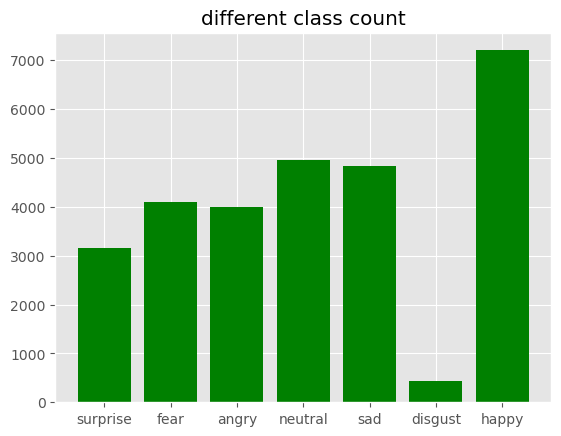

In [7]:
class_counts = {}
for dir in os.listdir(train_path):
    class_counts[dir] = len(os.listdir(train_path + '/' + dir))
plt.bar(class_counts.keys(), class_counts.values(), color='g')
plt.title("different class count");

- our dataset is slightly unblanced because "disgust" category has very few compared to other classes
- This needs to be balnced to avoid biasing in our training process
- we will use pytorch `WeightedRandomSampler` to sample the dataset

In [8]:
# create a label map
labels_map = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

In [9]:
# this function creates class weigths for torch weighted randomsampler
def assign_classweigths(data_set):
    ind = data_set.indices # get dataset indices
    imgs = data_set.dataset.imgs # get images and labels of original dataset
    labels = [imgs[i][1] for i in ind] # find the labels
    class_dist = Counter(labels) # create a dict of counts
    class_wt = {k: 1000/v for k,v in class_dist.items()} # asssign weights
    
    weights = [class_wt[l] for l in labels] # create weights for entire dataset
    return weights

In [10]:
# helper function for converting data into pytorch dataloader
def prepare_data(path, training_transform, validation_transform, validation_size = 0.3, BATCH_SIZE = 64):
    data = datasets.ImageFolder(root=path) # load data from folder
    # split into training and validation
    training_dataset, validation_dataset = random_split(data, [math.floor(len(data)*(1-validation_size)), 
                                                                     math.ceil(len(data)*validation_size)])

    # apply transform
    training_dataset.dataset.transform = training_transform
    validation_dataset.dataset.transform = validation_transform
    
    weights = assign_classweigths(training_dataset) # assign weights for training dataset
    
    sampler = WeightedRandomSampler(weights=torch.DoubleTensor(weights),
                                    num_samples = len(training_dataset), replacement=True)
    
    # load the the data into loader
    # create training loader
    train_loader = DataLoader(
        training_dataset, batch_size=BATCH_SIZE, sampler=sampler,
        num_workers=4, persistent_workers=True,
    )
    # create validation loader
    valid_loader = DataLoader(
        validation_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=4, persistent_workers=True,
    )

    # return the loaders
    return (train_loader, valid_loader)

In [11]:
# helper function to visualize loader class distribution
def visualize_dataloader(loader, color='gray'):
    class_distribution = {}
    class_labels = []
    
    for i, (inputs, labels) in enumerate(loader):
        class_labels.extend(labels.numpy())
    
    class_distribution = {labels_map[k]: v for k,v in Counter(class_labels).items()}
    
    plt.bar(class_distribution.keys(), class_distribution.values(), color='gray')
    plt.show()

In [12]:
# define transform for initial image processing

# training transform
training_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Normalize((0.5,),(0.5,))]
)

#validation transfrom
validation_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Normalize((0.5,),(0.5,))]
)

In [13]:
# get the loaders
train_loader, valid_loader = prepare_data("/kaggle/input/fer2013/train", training_transform, validation_transform)

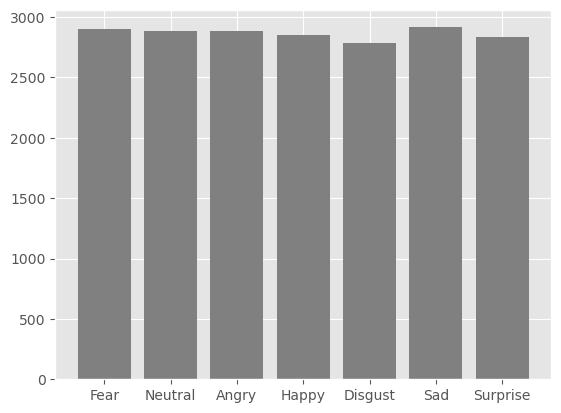

In [14]:
visualize_dataloader(train_loader)

- we observe the training loader is balanced now

### Visulaize the training dataset and its labels

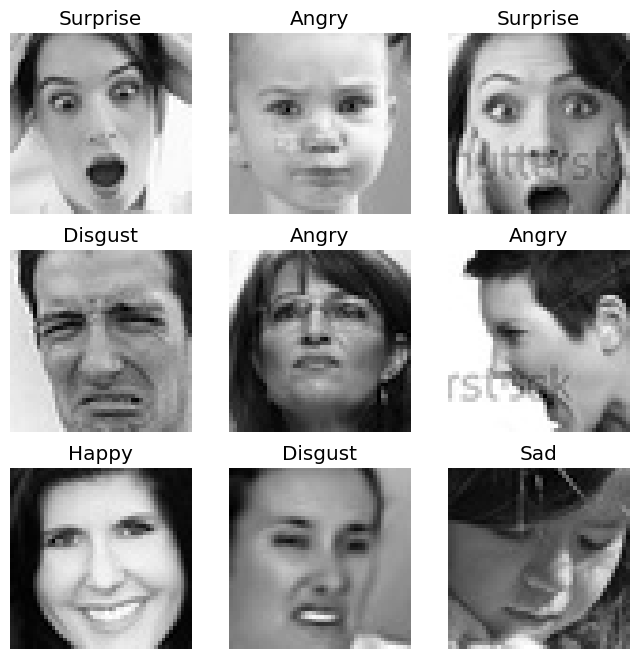

In [15]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # get random sample id
    sample_idx = torch.randint(len(train_loader), size=(1,)).item()
    img, label = next(iter(train_loader))
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label[0].item()])
    plt.axis("off")
    plt.imshow(img[0].squeeze(), cmap="gray")
plt.show()

- some of the data labels are not intutive like the first one in the 3rd column labeled `fear`. This might cause low accuracy of the overall perfomance

### Let's build our model
The approach will be to start with relatively simple model and incrementally increase it's complexcities

In [16]:
# helper class for early stopping
# stops training early if min loss value
# does not improve for 5 epochs
class EarlyStopping:
    def __init__(self, tolerance=5):

        self.tolerance = tolerance # nubmber of epochs before it stops
        self.counter = 0
        self.early_stop = False
        self.previous_loss = 0
        self.current_loss = 0
        self.min_loss = 1e5

    def __call__(self, loss):
        self.previous_loss = self.current_loss
        self.current_loss = loss
        if loss < self.min_loss:
            self.min_loss = loss

        if self.current_loss > self.min_loss:
            self.counter += 1
        else:
            self.counter = 0

        if self.counter >= self.tolerance:
            self.early_stop = True

In [17]:
# write training and validaton training loop helper function for single epoch
def train(model, trainloader, optimizer, criterion):
    # set model to training mode
    model.train()
    train_running_loss = 0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        images, labels = data
        # send it to computing device
        images = images.to(device)
        labels = labels.to(device)
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate loss
        loss = criterion(output, labels)
        # accumulate loss
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [18]:
# validation
def validate(model, testloader, criterion):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [19]:
def train_n_validate(model, loader, criterion, optimizer, epochs = 10, scheduler = None, tolerance = 5, verbose = 0):
    # lists to keep track of losses and accuracies
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    train_loader, valid_loader = loader
    # instantiate earlystopping class
    # stop training if validation accuracy does not improve
    # by delta% for tolerance epochs
    early_stopping = EarlyStopping(tolerance=tolerance)

    # start the training
    for epoch in range(epochs):
        if verbose > 0: print("training...")
        train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                                    optimizer, criterion)
        if verbose > 0: print("validating...")
        valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                        criterion)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        if scheduler:
            scheduler.step()
        if verbose > 0:
            print(f"\n[INFO]: Epoch {epoch+1} of {epochs}")
            print(f"training loss: {train_epoch_loss:.3f}, training accuracy: {train_epoch_acc:.3f}")
            print(f"validation loss: {valid_epoch_loss:.3f}, validation accuracy: {valid_epoch_acc:.3f}")
            print('-'*50)
        # early stopping
        early_stopping(valid_epoch_loss)
        if early_stopping.early_stop:
            print("training stopped early at epoch:", epoch + 1)
            break

    return((train_acc, valid_acc), (train_loss, valid_loss))

In [20]:
def plot_progress(train_acc, valid_acc, train_loss, valid_loss, model_name = 'model'):
    """
    Function to plot the loss and accuracy.
    """
    figure = plt.figure(figsize=(10, 4))
    # accuracy plots
    figure.add_subplot(1, 2, 1)
    plt.plot(
      train_acc, color='green', linestyle='-',
      label='train accuracy'
    )
    plt.plot(
      valid_acc, color='blue', linestyle='-',
      label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss plots
    figure.add_subplot(1, 2, 2)
    plt.plot(
      train_loss, color='orange', linestyle='-',
      label='train loss'
    )
    plt.plot(
      valid_loss, color='red', linestyle='-',
      label='validataion loss'
    )
    figure.suptitle(f'{model_name} performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

## Build models

### LeNet5
First we will use classic LeNet5 architecture as our baseline model
<p>Here is its architecture.</p>
<p>In our case input size is <strong>48x48</strong> and output size is <strong>7</strong></p>


![](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-52-17.png)

In [21]:
# build model
class leNet(nn.Module):

    def __init__(self):
        super(leNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
# set available device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Available computation device: {device}")

Available computation device: cuda


#### Inspect our model architecture and parameters

In [23]:
# instantiate model
model = leNet()
print(model)

# print model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of model parameters: {total_params}")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total number of trainable model parameters: {total_trainable_params}")

leNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)
total number of model parameters: 168971
total number of trainable model parameters: 168971


In [24]:
# prepare data loader
lenet_loader = prepare_data("/kaggle/input/fer2013/train", training_transform, validation_transform)

- start training

In [25]:
# instantiate model
model = leNet().to(device)

# set training parameters
lr = 1e-3
epochs = 50
# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model, lenet_loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

training...
validating...

[INFO]: Epoch 1 of 50
training loss: 1.946, training accuracy: 15.058
validation loss: 1.953, validation accuracy: 12.211
--------------------------------------------------
training...
validating...

[INFO]: Epoch 2 of 50
training loss: 1.942, training accuracy: 16.174
validation loss: 1.947, validation accuracy: 15.095
--------------------------------------------------
training...
validating...

[INFO]: Epoch 3 of 50
training loss: 1.935, training accuracy: 17.924
validation loss: 1.940, validation accuracy: 16.502
--------------------------------------------------
training...
validating...

[INFO]: Epoch 4 of 50
training loss: 1.923, training accuracy: 19.758
validation loss: 1.935, validation accuracy: 19.002
--------------------------------------------------
training...
validating...

[INFO]: Epoch 5 of 50
training loss: 1.911, training accuracy: 20.122
validation loss: 1.903, validation accuracy: 21.351
--------------------------------------------------


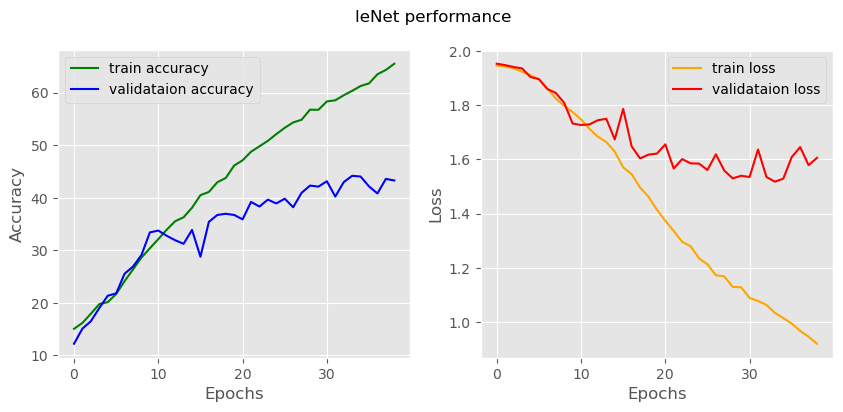

In [26]:
# plot trainign progress
plot_progress(train_acc, valid_acc, train_loss, valid_loss, model_name='leNet')

#### Observation
- The model quickly overfits
- Validation loss stopped decreasing around epoch 27
- Validation loss curve is not smooth, probably because of high momentum term

### Add `Dropout` layer to tackle overfitting

In [27]:
# build model with dropout regulerization
class leNet_do(nn.Module):

    def __init__(self):
        super(leNet_do, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flat = nn.Flatten()
        self.do = nn.Dropout(0.3) # add dropout
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.do(x)
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.do(x)
        x = F.relu(self.fc2(x))
        x = self.do(x)
        x = self.fc3(x)
        return x

In [28]:
# instantiate model
model_reg1 = leNet_do()
print(model_reg1)

# print model parameters
total_params = sum(p.numel() for p in model_reg1.parameters())
print(f"total number of model parameters: {total_params}")

total_trainable_params = sum(p.numel() for p in model_reg1.parameters() if p.requires_grad)
print(f"total number of trainable model parameters: {total_trainable_params}")

leNet_do(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (do): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)
total number of model parameters: 168971
total number of trainable model parameters: 168971


In [ ]:
# instantiate model with dropout
model_reg1 = leNet_do().to(device)

# set training parameters
lr = 1e-3
epochs = 50
# optimizer
optimizer = optim.SGD(model_reg1.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_reg1, lenet_loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

training...
validating...

[INFO]: Epoch 1 of 50
training loss: 1.947, training accuracy: 14.360
validation loss: 1.950, validation accuracy: 11.199
--------------------------------------------------
training...
validating...

[INFO]: Epoch 2 of 50
training loss: 1.946, training accuracy: 14.544
validation loss: 1.945, validation accuracy: 11.245
--------------------------------------------------
training...
validating...

[INFO]: Epoch 3 of 50
training loss: 1.945, training accuracy: 15.880
validation loss: 1.941, validation accuracy: 19.851
--------------------------------------------------
training...
validating...

[INFO]: Epoch 4 of 50
training loss: 1.943, training accuracy: 17.161
validation loss: 1.940, validation accuracy: 18.874
--------------------------------------------------
training...
validating...

[INFO]: Epoch 5 of 50
training loss: 1.941, training accuracy: 18.397
validation loss: 1.939, validation accuracy: 18.665
--------------------------------------------------


In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss, model_name='leNet with DO')

### $Note$
-  Clearly with dropout layers, the model is not overfitting like previous case
- Validation loss and accuracy also increases slightly
- Let us see effect of **image augmentation** as a regulerizer

### Image augmentation

In [ ]:
# create trandforms using augmentation
# we will not be using augmentation in the validation set
training_augment = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.5)]
)

In [ ]:
# create loader
augment_loader = prepare_data(train_path, training_augment, validation_transform)

- start training

In [ ]:
# instantiate model
model_aug = leNet().to(device)

# set training parameters
lr = 1e-3
epochs = 50
# optimizer
optimizer = optim.SGD(model_aug.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_aug, augment_loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss, model_name='leNet with augmentation')

### $Note$
- with dataset augmentation we could address the overfitting problem to some extent, but the accuracy score is not improving beyond 40%
- seems less effective than adding dropout layers
- we need to increse the model complexity to get more accurate result

### $AlexNet$ architecture
![](https://www.oreilly.com/api/v2/epubs/9781789956177/files/assets/ec08175c-5282-4be2-b6e7-6f2d99272166.png)

In [ ]:
# training transform
alex_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)), # alexnet takes 3d input
        transforms.Resize(128), # increase size to cater to the deep cnn layers
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomResizedCrop(128), # add random cropping
        transforms.RandomRotation((-30,30))]
)
# validation transform
alex_valid_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
        transforms.Resize(128)]
)

In [ ]:
alex_loader = prepare_data(train_path, alex_transform, alex_valid_transform, BATCH_SIZE=64)

In [ ]:
# load alexnet
model_alex = models.alexnet(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_alex.classifier[6].in_features
model_alex.fc = nn.Linear(num_ftrs, 7) # change final layer as our need

model_alex = model_alex.to(device)

In [ ]:
# set training parameters
lr = 1e-3
epochs = 30
# optimizer
optimizer = optim.SGD(model_alex.parameters(), lr=lr, nesterov=True, momentum=0.5)
# loss function
criterion = nn.CrossEntropyLoss()
#lr_scheduler
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_alex, alex_loader, criterion,
                                                                    optimizer, epochs = epochs,
                                                                    scheduler=scheduler, verbose = 1)

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss, model_name='alexNet')

**Observations**
- Able to touch 50% accuracy
- Does not overfit significantly
- Need more complex architecture to get more accuracy

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
fc_layer = model_vgg16.classifier[6]
num_ftrs = fc_layer.in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, 7)

model_vgg11 = model_vgg16.to(device)

In [ ]:
# training transform
vgg_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
        transforms.Resize(128),
        transforms.RandomPerspective(distortion_scale=0.6, p=0.3),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomResizedCrop(128),
        transforms.RandomRotation(30),]
)
# validation transform
vgg_valid_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
        transforms.Resize(128)]
)

In [ ]:
vgg_loader = prepare_data(train_path, vgg_transform, vgg_valid_transform, BATCH_SIZE=64)

In [ ]:
# set training parameters
lr = 1e-3
epochs = 50
# optimizer
optimizer = optim.SGD(model_vgg16.parameters(), lr=lr, momentum=0.5, nesterov=True)
# loss function
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_vgg16, vgg_loader, criterion,
                                                                    optimizer, epochs=epochs, verbose=1)

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss, model_name='vgg16')

**observation**
- model still overfits after some epoch but able to achieve 60% validation accuracy
- maybe we should try more learning rate decay to apply in the later stages of learning

## Inference

In [ ]:
def visualize_model(model, validation_loader, num_images=9):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8,8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {labels_map[preds[j].item()]}\nactual: {labels_map[labels[j].item()]}', fontsize=8)
                plt.imshow(inputs.cpu().data[j][0], cmap='gray')

                if images_so_far == num_images:
                    return

In [ ]:
visualize_model(model_vgg16, vgg_loader[1])

**observaions**

- some images

### Inspect output from different layers

In [ ]:
t = next(iter(vgg_loader[0]))
im = t[0][0][0].detach()

nrow, ncol = 4, 5
fig, axs = plt.subplots(nrow, ncol, figsize=(10,8))


sequential = model_vgg16.features
x = t[0].to(device)
# numer of layers to be viewed
layer_num = 20
for i in range(layer_num):
    r, c = i//(nrow+1), i%ncol
    x = sequential[i](x)
    a = axs[r,c]
    a.imshow(x[0][0].to('cpu').detach())
    a.set_title(f'layer {i}')
    a.axis('off');
fig.tight_layout()

## Inference on test set

In [ ]:
test_path = "/kaggle/input/fer2013/test"

#validation transfrom
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
     transforms.Resize(128)]
)

test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64,
                         num_workers=4, persistent_workers= True)

In [ ]:
visualize_dataloader(test_loader, color='b')

In [ ]:
test_loader, _ = prepare_data(test_path, test_transform, test_transform, validation_size=0.001, BATCH_SIZE=64)

In [ ]:
visualize_dataloader(test_loader)

In [ ]:
visualize_model(model_vgg16, test_loader)

In [ ]:
def generate_prediction(model, testdata_loader):
    y_pred, y_true = [], []
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testdata_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    return (y_true, y_pred)

In [ ]:
y_true, y_pred = generate_prediction(model_vgg16, test_loader)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=np.array(list(labels_map.values()))).plot()
plt.grid(False);